# Homework 4 Sample Solution

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve,recall_score,accuracy_score
import scikitplot as skplt

    Step 1

In [39]:
data=pd.read_excel("Telecom_Churn.xls")

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Eve Mins          3333 non-null float64
Night Mins        3333 non-null float64
Intl Mins         3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
State             3333 non-null object
Area Code         3333 non-null int64
Phone             3333 non-null object
dtypes: float64(8), int64(11), object(2)
memory usage: 546.9+ KB


In [41]:
#first, let's remove spaces in the names of variables
data.columns = data.columns.str.replace(' ', '_')

In [42]:
#let's drop the variables which do not provide any meaningful information
data=data.drop(["Area_Code","Phone"],axis=1)

    Step 2

In [43]:
data.isnull().sum()

Account_Length    0
VMail_Message     0
Day_Mins          0
Eve_Mins          0
Night_Mins        0
Intl_Mins         0
CustServ_Calls    0
Churn             0
Int'l_Plan        0
VMail_Plan        0
Day_Calls         0
Day_Charge        0
Eve_Calls         0
Eve_Charge        0
Night_Calls       0
Night_Charge      0
Intl_Calls        0
Intl_Charge       0
State             0
dtype: int64

    No missing values.

    Step 3

In [44]:
data.var()

Account_Length    1585.800121
VMail_Message      187.371347
Day_Mins          2966.696487
Eve_Mins          2571.894016
Night_Mins        2557.714002
Intl_Mins            7.794368
CustServ_Calls       1.730517
Churn                0.123951
Int'l_Plan           0.087544
VMail_Plan           0.200165
Day_Calls          402.768141
Day_Charge          85.737128
Eve_Calls          396.910999
Eve_Charge          18.581856
Night_Calls        382.930472
Night_Charge         5.179597
Intl_Calls           6.057576
Intl_Charge          0.568173
dtype: float64

In [45]:
data.nunique()

Account_Length     212
VMail_Message       46
Day_Mins          1667
Eve_Mins          1611
Night_Mins        1591
Intl_Mins          162
CustServ_Calls      10
Churn                2
Int'l_Plan           2
VMail_Plan           2
Day_Calls          119
Day_Charge        1667
Eve_Calls          123
Eve_Charge        1440
Night_Calls        120
Night_Charge       933
Intl_Calls          21
Intl_Charge        162
State               51
dtype: int64

    Also, there is no variable withh less than 2 categories and 0 variance.

    Step 4

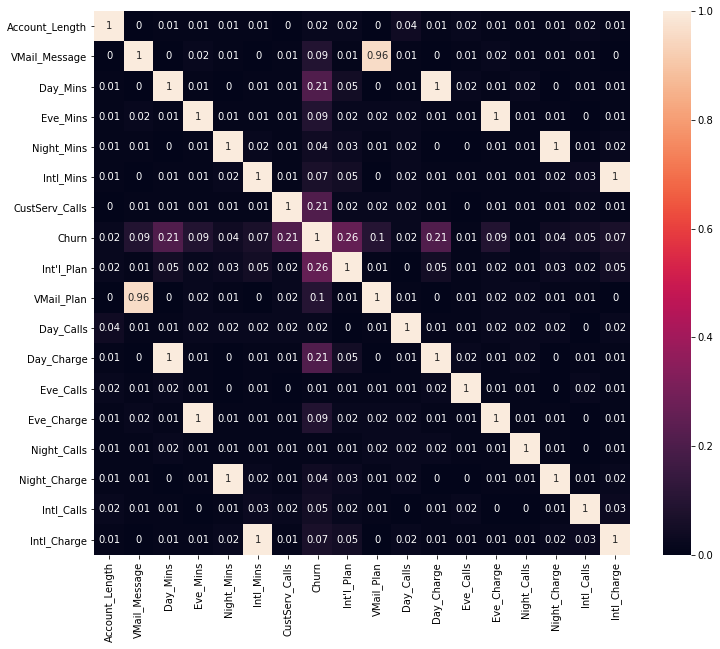

In [46]:
#let's check correlations between numeric variables
plt.figure(figsize=(12,10))
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

    I'll drop VMail_Messages as it's highly correlated with VMail_Plan. I'm keeping VMail_Plan as it has only 2 categories      compared to VMail_Messages. Also, I'll drop Day_Mins, Eve_Mins, Night_Mins, and Intl_Mins as these variables have 100%     correlation with Day_Charge, Eve_Charge, Night_Charge, and Intl_Charge respectively. I've decided to keep variables which   show costs not minutes.

In [47]:
data.drop(["VMail_Message","Day_Mins","Eve_Mins","Night_Mins","Intl_Mins"],axis=1,inplace=True)

    Step 5

In [48]:
data=pd.get_dummies(data,drop_first=True)

In [49]:
X=data.drop("Churn",axis=1)
Y=data.Churn
#let's do train and test split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [50]:
Y.value_counts()/len(Y)*100

0    85.508551
1    14.491449
Name: Churn, dtype: float64

    About 85.5% of customers didn't churn.This means that without any model we will probably clasify a new record (a new       customer) as 0 with accuracy of 85.5%. 

    Step 6

<h3> Model 1: Finding optimal parameters for DT with GridSearchCV and Running the Tree with optimal parameters </h3>

In [92]:
#let's get optimal parameters in specified ranges
gridsearch=GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight="balanced"),param_grid={
                        'max_depth':(5,10),
                        "min_samples_leaf":(50,250,50)
                    },cv=5,scoring="roc_auc",n_jobs=-1).fit(x_train,y_train)
#let's see the optimal parameters
print("Best parameters:",gridsearch.best_params_)

#the mean roc_auc score for train data based on gridsearchcv results
print("mean roc_auc score:",gridsearch.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 50}
mean roc_auc score: 0.8679115408745526


In [95]:
#let's construct DT with the best parameters 
tree=DecisionTreeClassifier(class_weight="balanced", max_depth=10, 
                             min_samples_leaf=50,random_state=42).fit(x_train,y_train)

<h3> Model 2: Finding optimal parameters for Logistic Regression with GridSearchCV and Running the Logit with optimal parameters </h3>

In [96]:
gridsearch2=GridSearchCV(LogisticRegression(random_state=42,class_weight="balanced"),
                                             param_grid={"penalty":["l1","l2"],"C":(0.0001,50)},
                                             scoring="roc_auc",
                                             cv=5,n_jobs=-1).fit(X,Y)
#let's see the optimal parameters
print("Best parameters:",gridsearch2.best_params_)

#the mean roc_auc score for train data based on gridsearchcv results
print("mean roc_auc score:",gridsearch2.best_score_)

Best parameters: {'C': 50, 'penalty': 'l2'}
mean roc_auc score: 0.8074153925837512


In [97]:
#let's construct Logit with the best parameters 
logit=LogisticRegression(C=50,penalty='l2',class_weight='balanced',random_state=42).fit(x_train,y_train)

    Step 7

<h3> Comparing the performance of 2 models </h3>

In [98]:
#let's create new dictionaries for models and scores
models2={"Decision Tree": tree, 
        "Logistic Regression": logit}
scores2={"Accuracy": accuracy_score,
        "ROC AUC": roc_auc_score,
       "Recall": recall_score}

In [99]:
#let's use for loop to fit models and print metrics for each model on Train data
print("Train Data")
for model_name, model in models2.items():
    print("\n",model_name)
    prediction=model.predict(x_train)
    for score_name, score in scores2.items():
        print(score_name,score(y_train,prediction).round(2)*100)

Train Data

 Decision Tree
Accuracy 86.0
ROC AUC 86.0
Recall 85.0

 Logistic Regression
Accuracy 78.0
ROC AUC 77.0
Recall 77.0


In [100]:
#Test data
print("Test Data")
for model_name, model in models2.items():
    print("\n",model_name)
    prediction=model.predict(x_test)
    for score_name, score in scores2.items():
        print(score_name,score(y_test,prediction).round(2)*100)

Test Data

 Decision Tree
Accuracy 86.0
ROC AUC 86.0
Recall 87.0

 Logistic Regression
Accuracy 79.0
ROC AUC 79.0
Recall 80.0


    The winner model is decision tree as the perofromance of the tree by all metrics is higher compared to logit, and it         does not overfit the train data.

    Step 8

In [102]:
#let's get feature importances
feat_imp=pd.DataFrame(tree.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp

,Feature_imp
Day_Charge,0.271465
CustServ_Calls,0.259646
Int'l_Plan,0.218545
Eve_Charge,0.060686
Intl_Calls,0.056205
VMail_Plan,0.035920
Intl_Charge,0.027202
Night_Charge,0.023261
Night_Calls,0.021965
Account_Length,0.014596


    As it can be observed the States does not provide any meaningful information in the construction of tree. So, the next      step should be removing State variable from the data and running the model again.  
    
    Let's plot the first 11 most important variables. 

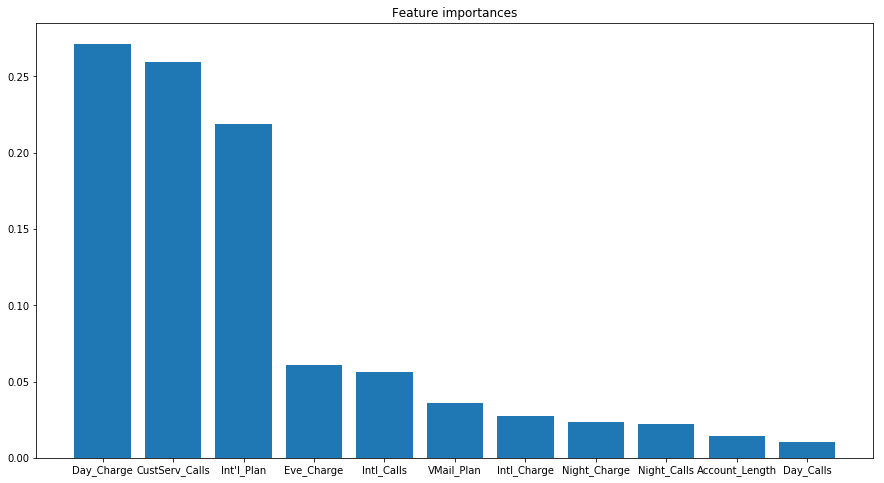

In [117]:
plt.figure(figsize=(15,8))
plt.bar(feat_imp.index[0:11],feat_imp.Feature_imp[0:11])
plt.title("Feature importances")
plt.show()

    Step 9

<h3>Gain and Lift charts </h3>

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


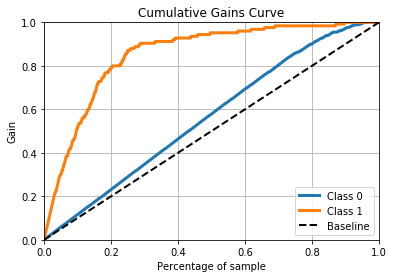

In [120]:
#Cummulative gain curve
skplt.metrics.plot_cumulative_gain(y_test,tree.predict_proba(x_test))
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


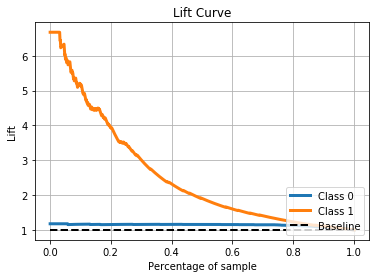

In [122]:
#lift curve
skplt.metrics.plot_lift_curve(y_test,tree.predict_proba(x_test))
plt.show()